In [2]:
# General libraries
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Qibo libraries
import qibo
from qibo import hamiltonians as ham, matrices as m
from qibo import gates, models
from qibo.models import Circuit
from qibo.models.utils import matrix_to_pauli_operators
import numpy as np

warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
def ising_chain_ham_qibo(n, gam):
    
    # n = number of spin positions
    # gam = transverse field parameter
    
    for i in range(n):
        vecX = [m.I] * n
        vecZ = [m.I] * n
        vecX[i] = m.X
        vecZ[i] = m.Z
        
        if i == n - 1:
            vecX[0] = m.X
        else:
            vecX[i+1] = m.X

        auxX = vecX[0]
        auxZ = vecZ[0]
        
        for a in vecX[1:n]:
            auxX = np.kron(auxX, a)
        for b in vecZ[1:n]:
            auxZ = np.kron(auxZ, b)
            
        if i == 0:
            H = (auxX) + (gam * auxZ)
        else:
            H = H + (auxX) + (gam * auxZ)

    return ham.Hamiltonian(n, H)

In [4]:
# Create a Ising Hamiltonian to minimize with VQE and Rotosolve optimizer
n = 4 # número de qubits
gam = 0.3

H = ising_chain_ham_qibo(n, gam) # Creamos el Hamiltoniano

# Pauli decomposition operators
print("Estructura del Hamiltoniano en matrices de Pauli:")
print("--------------------------------------------------")
matrix_to_pauli_operators(H.matrix)

[Qibo 0.2.9|INFO|2024-06-12 09:50:42]: Using numpy backend on /CPU:0


Estructura del Hamiltoniano en matrices de Pauli:
--------------------------------------------------


{'IIIZ': 0.3,
 'IIXX': 1.0,
 'IIZI': 0.29999999999999993,
 'IXXI': 1.0,
 'IZII': 0.3,
 'XIIX': 1.0,
 'XXII': 1.0,
 'ZIII': 0.29999999999999993}

In [5]:
nqubits = 4
nlayers = 3

# Create variational ansatz circuit Twolocal
ansatz = models.Circuit(nqubits)
for l in range(nlayers):
    
    ansatz.add((gates.RY(q, theta=0) for q in range(nqubits)))
    
    for i in range(nqubits - 3):
        ansatz.add(gates.CNOT(i, i+1))
        ansatz.add(gates.CNOT(i, i+2))
        ansatz.add(gates.CNOT(i+1, i+2))
        ansatz.add(gates.CNOT(i, i+3))
        ansatz.add(gates.CNOT(i+1, i+3))
        ansatz.add(gates.CNOT(i+2, i+3))
    
ansatz.add((gates.RY(q, theta=0) for q in range(nqubits)))

print(ansatz.draw())

q0: ─RY─o─o───o─────RY─o─o───o─────RY─o─o───o─────RY─
q1: ─RY─X─|─o─|─o───RY─X─|─o─|─o───RY─X─|─o─|─o───RY─
q2: ─RY───X─X─|─|─o─RY───X─X─|─|─o─RY───X─X─|─|─o─RY─
q3: ─RY───────X─X─X─RY───────X─X─X─RY───────X─X─X─RY─


In [6]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'exp_val': [],
}

# Callback function for intermediate values on each epoch
def callback(theta_optimal, expectation_vals, nevals):

    intermediate_info['nfev'].append(nevals)
    intermediate_info['parameters'].append(theta_optimal)
    intermediate_info['exp_val'].append(expectation_vals)

# Create VQE model
vqe = models.VQE(ansatz, H)

# Optimize starting from a random guess to set the initial parameters
nparams = 16
initial_parameters = np.random.random(nparams) # valor inicial

# Rotosolve options
options = {
            'max_steps': 50,
            'step_size' : 1,
            'num_params' : nparams,
          }

result, params, extra = vqe.minimize(initial_parameters,
                                     method='rotosolve', # select rotosolve as optimizer
                                     callback = callback,
                                     options = options,
                                     compile=False)

Rotosolve circuit optimization steps
Step 0. Current expectation value: -3.97869898
Step 1. Current expectation value: -4.07394079
Step 2. Current expectation value: -4.08295959
Step 3. Current expectation value: -4.08509383
Step 4. Current expectation value: -4.08634917
Step 5. Current expectation value: -4.08721330
Step 6. Current expectation value: -4.08783435
Step 7. Current expectation value: -4.08829526
Step 8. Current expectation value: -4.08864642
Step 9. Current expectation value: -4.08891952
Step 10. Current expectation value: -4.08913538
Step 11. Current expectation value: -4.08930826
Step 12. Current expectation value: -4.08944828
Step 13. Current expectation value: -4.08956284
Step 14. Current expectation value: -4.08965745
Step 15. Current expectation value: -4.08973626
Step 16. Current expectation value: -4.08980249
Step 17. Current expectation value: -4.08985859
Step 18. Current expectation value: -4.08990651
Step 19. Current expectation value: -4.08994775
Step 20. Curr

In [7]:
print("Results:")
print("--------")
print(result)

Results:
--------
[-3.9786989761571263, -4.073940785221439, -4.082959593139201, -4.085093825655079, -4.0863491745272755, -4.08721330371466, -4.087834352937001, -4.088295258520269, -4.088646417417638, -4.088919523152884, -4.089135384791454, -4.0893082627372745, -4.089448284776855, -4.089562843463695, -4.089657446900719, -4.089736263859947, -4.08980248854491, -4.0898585931329325, -4.089906507248937, -4.089947748116593, -4.0899835164719045, -4.090014768183799, -4.0900422683298325, -4.090066632412346, -4.090088358029875, -4.090107849386529, -4.0901254363761455, -4.090141389522615, -4.090155931732116, -4.090169247577074, -4.090181490658489, -4.090192789464925, -4.0902032520503955, -4.090212969780711, -4.090222020342597, -4.090230470167571, -4.090238376389878, -4.090245788432455, -4.090252749295272, -4.090259296604792, -4.090265463471441, -4.090271279192298, -4.090276769828741, -4.090281958682864, -4.090286866691714, -4.09029151275472, -4.09029591400659, -4.090300086045675, -4.09030404312580

In [8]:
print("Optimized parameters:")
print("---------------------")
print(params)

Optimized parameters:
---------------------
[-3.14068506 -0.77991446 -6.3313567   1.34373318 -0.00677308 -0.74014689
 -0.21929011  0.20871556  0.26057692 -0.54934786  1.26923769  0.01075238
  1.15442254 -6.20513635  0.42026863  0.15535393]


In [9]:
print("Execution summary:")
print("------------------")
print(extra)

Execution summary:
------------------
{'x': array([-3.14068506, -0.77991446, -6.3313567 ,  1.34373318, -0.00677308,
       -0.74014689, -0.21929011,  0.20871556,  0.26057692, -0.54934786,
        1.26923769,  0.01075238,  1.15442254, -6.20513635,  0.42026863,
        0.15535393]), 'fun': -4.090311363648195, 'exp_vals': [-3.9786989761571263, -4.073940785221439, -4.082959593139201, -4.085093825655079, -4.0863491745272755, -4.08721330371466, -4.087834352937001, -4.088295258520269, -4.088646417417638, -4.088919523152884, -4.089135384791454, -4.0893082627372745, -4.089448284776855, -4.089562843463695, -4.089657446900719, -4.089736263859947, -4.08980248854491, -4.0898585931329325, -4.089906507248937, -4.089947748116593, -4.0899835164719045, -4.090014768183799, -4.0900422683298325, -4.090066632412346, -4.090088358029875, -4.090107849386529, -4.0901254363761455, -4.090141389522615, -4.090155931732116, -4.090169247577074, -4.090181490658489, -4.090192789464925, -4.0902032520503955, -4.090212969

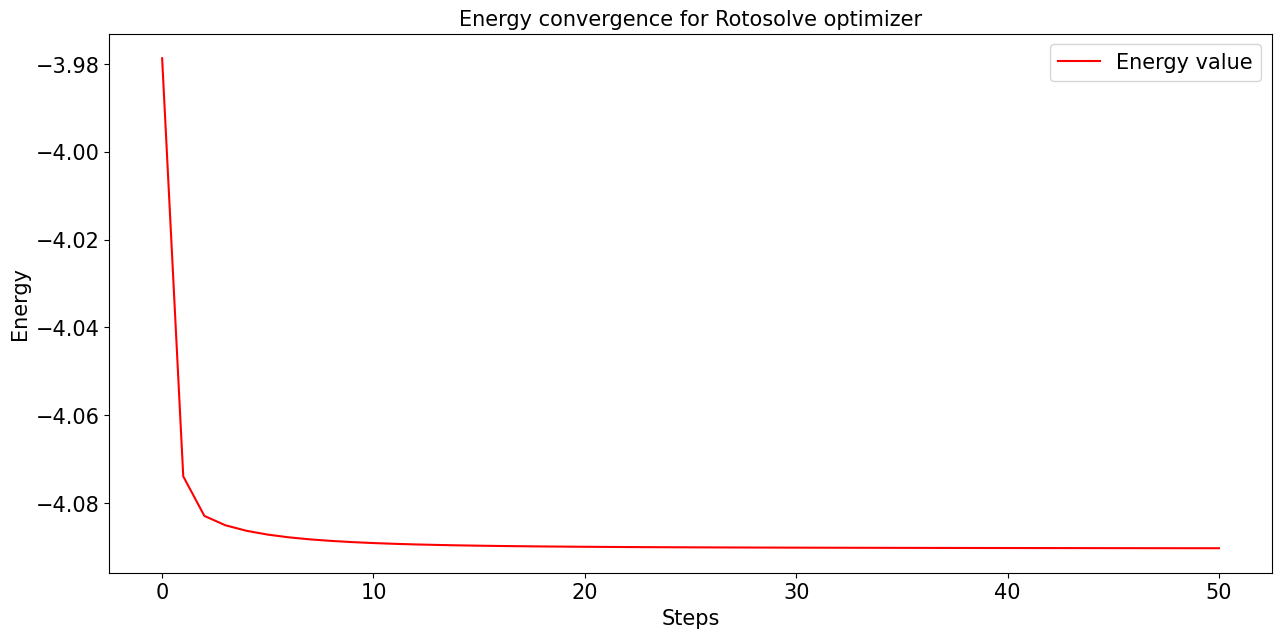

In [10]:
final_result = intermediate_info['exp_val']

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(final_result)), final_result, label="Energy value", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
plt.title('Energy convergence for Rotosolve optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

In [11]:
print("Best energy result:", np.min(result))
print("Mean energy result:", np.mean(result))

Best energy result: -4.090311363648195
Mean energy result: -4.087071425313556
